<a href="https://colab.research.google.com/github/ShivaSurender/Quora-Question-Pair-Similarity-Detection/blob/master/Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import distance
from os import path
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
train=pd.read_csv("train.csv")

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


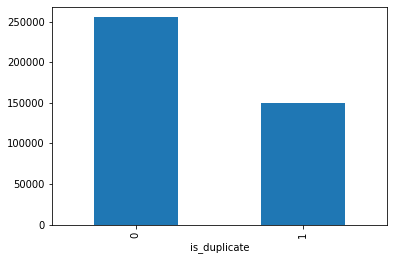

In [ ]:
train.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
print("total number of question pairs for training:\n",format(train.shape[0]))

total number of question pairs for training:
 404290


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(round((train[train.is_duplicate==0].shape[0]/train.shape[0])*100,2)))
print('~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round((train[train.is_duplicate==1].shape[0]/train.shape[0])*100,2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%
~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [ ]:
nan_rows=train[train.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
train=train.fillna(' ')
nan_rows=train[train.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
qids=pd.Series(train['question1'].tolist()+train['question2'].tolist())
unique_qids=len(np.unique(qids))
qids_morethan_onetime=np.sum(qids.value_counts()>1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qids))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qids_morethan_onetime,qids_morethan_onetime/unique_qids*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

q_vals=qids.value_counts()

q_vals=q_vals.values


Total number of  Unique Questions are: 537361

Number of unique questions that appear more than one time: 111873 (20.818965276601766%)

Max number of times a single question is repeated: 161



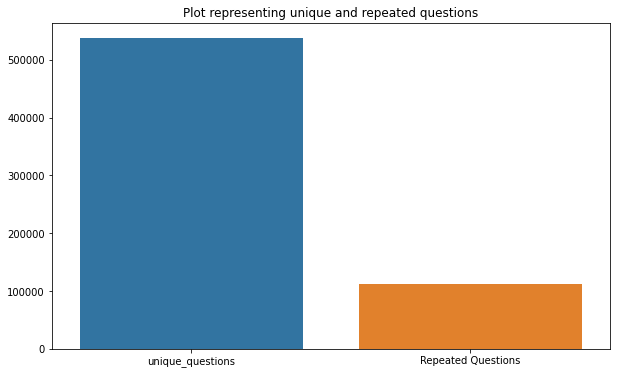

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Plot representing unique and repeated questions')
sns.barplot(x=["unique_questions" , "Repeated Questions"],y=[unique_qids,qids_morethan_onetime])
plt.show()

In [ ]:
pair_duplicates=train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("No. of Duplicates:",pair_duplicates.shape[0]-train.shape[0])

No. of Duplicates: 0


Maximum number of times a single question is repeated: 161



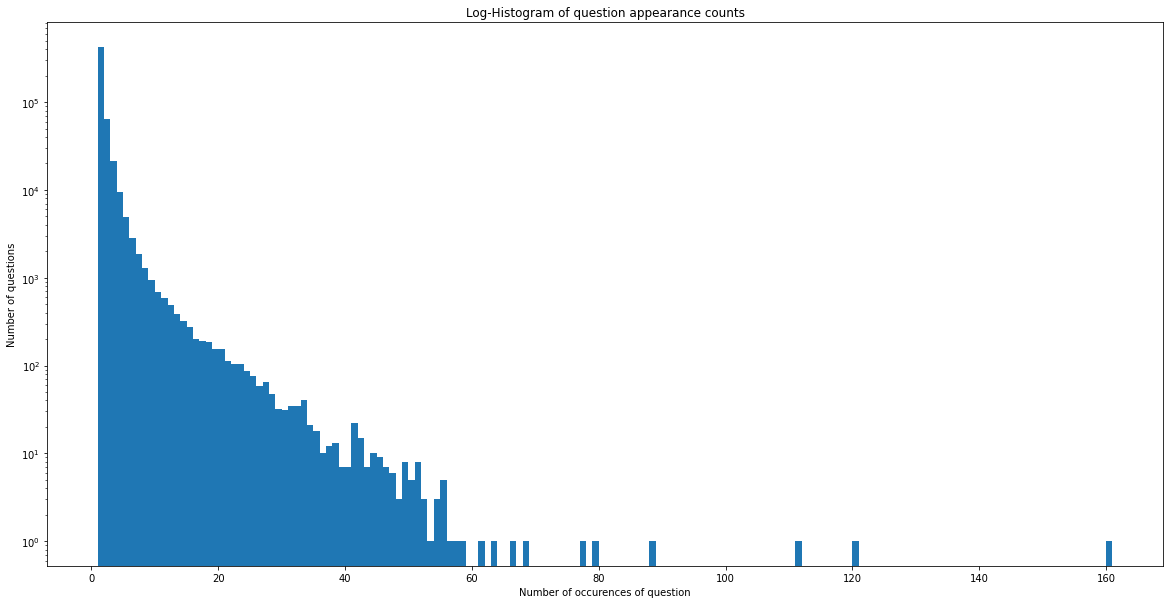

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
  train=pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
  train['freq_qid1']=train.groupby('qid1')['qid1'].transform('count')
  train['freq_qid2']=train.groupby('qid2')['qid2'].transform('count')
  train['q1len']=train['question1'].str.len()
  train['q2len']=train['question2'].str.len()
  train['q1_n_words']=train['question1'].apply(lambda x: len(x.split(" ")))
  train['q2_n_words']=train['question2'].apply(lambda x: len(x.split(" ")))

  def normalized_word_common(row):
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
  train['word_Common']=train.apply(normalized_word_common,axis=1)
  def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1)+len(w2))
  train['word_Common']=train.apply(normalized_word_Total,axis=1) 
  def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
  train['word_share'] = train.apply(normalized_word_share, axis=1)
  
  train['freq_q1+q2'] = train['freq_qid1']+train['freq_qid2']
  train['freq_q1-q2'] = abs(train['freq_qid1']-train['freq_qid2'])

  train.to_csv("df_fe_without_preprocessing_train.csv", index=False)

train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,20.0,0.100000,4,2


In [ ]:
print ("Minimum length of the questions in question1 : " , min(train['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(train['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


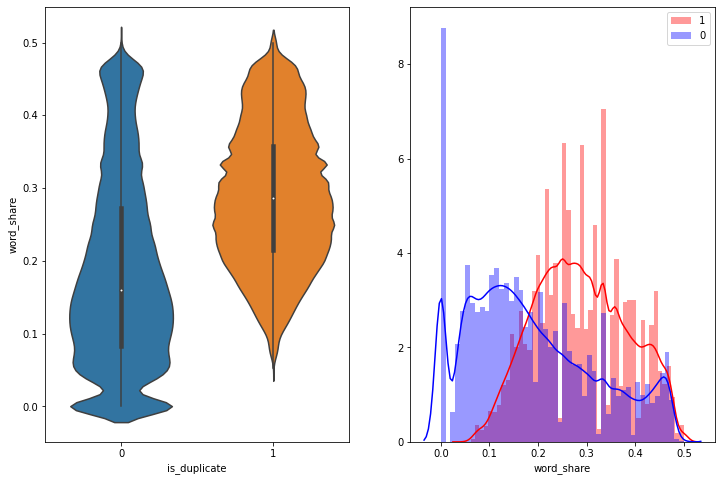

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=train)

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate']==1.0]["word_share"],label="1",color="red")
sns.distplot(train[train['is_duplicate']==0.0]["word_share"],label="0",color="blue")
plt.legend()
plt.show()

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    train = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    train = train.fillna('')
    train.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [ ]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,20.0,0.100000,4,2


In [ ]:
import nltk
nltk.download('stopwords')

STOP_WORDS = stopwords.words("english")

def preprocess(x):
  x=str(x).lower()
  x=x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)


  porter=PorterStemmer()
  pattern=re.compile('\W')

  if type(x)==type(''):
    x=re.sub(pattern,' ',x)
    
  if type(x)==type(''):
    x=porter.stem(x)
    example1=BeautifulSoup(x)
    x=example1.get_text()

  return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Advance feature engineering  techniques
safe_div=0.0001

def get_token_features(q1,q2):
  token_features=[0.0]*10

  #converting the sentence into tokens
  q1_tokens=q1.split()
  q2_tokens=q2.split()

  if len(q1_tokens)==0 or len(q2_tokens)==0:
    return token_features
  #Get the non-stopwords in Questions
  q1_words=set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_words=set([word for word in q2_tokens if word not in STOP_WORDS])

  #Get the stopwords in Questions
  q1_stops=set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops=set([word for word in q2_tokens if word in STOP_WORDS])

  #Get te common non-stopwords in Questions
  common_word_count=len(q1_words.intersection(q2_words))

  #Get te common non-stopwords in Questions
  common_stop_count=len(q1_stops.intersection(q2_stops))

  #Get te common Tokens in Questions pair
  common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))

  token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+safe_div)
  token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+safe_div)
  token_features[2]=common_stop_count/(min(len(q1_stops),len(q2_stops))+safe_div)
  token_features[3]=common_stop_count/(max(len(q1_stops),len(q2_stops))+safe_div)
  token_features[4]=common_token_count/(max(len(q1_tokens),len(q2_tokens))+safe_div)
  token_features[5]=common_token_count/(max(len(q1_tokens),len(q2_tokens))+safe_div)
  token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])
  token_features[7]=int(q1_tokens[0]==q2_tokens[0])
  token_features[8]=abs(len(q1_tokens)-len(q2_tokens))

  token_features[9]=(len(q1_tokens)+len(q2_tokens))/2
  
  return token_features

def get_longest_substr_ratio(a,b):
  strs=list(distance.lcsubstrings(a,b))
  if len(strs)==0:
      return 0
  else:
      return len(strs[0])/(min(len(a),len(b))+1)

def extract_features(df):
  #preprocessing each question
  train["question1"] = train["question1"].fillna("").apply(preprocess)
  train["question2"] = train["question2"].fillna("").apply(preprocess)

  print("token features...")

  # Merging  Features with dataset

  token_features = train.apply(lambda x: get_token_features(x['question1'],x['question2']),axis=1)
  
  train["cwc_min"]       = list(map(lambda x: x[0], token_features))
  train["cwc_max"]       = list(map(lambda x: x[1], token_features))
  train["csc_min"]       = list(map(lambda x: x[2], token_features))
  train["csc_max"]       = list(map(lambda x: x[3], token_features))
  train["ctc_min"]       = list(map(lambda x: x[4], token_features))
  train["ctc_max"]       = list(map(lambda x: x[5], token_features))
  train["last_word_eq"]  = list(map(lambda x: x[6], token_features))
  train["first_word_eq"] = list(map(lambda x: x[7], token_features))
  train["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
  train["mean_len"]      = list(map(lambda x: x[9], token_features))
  
  print("fuzzy features....")

  train["token_set_ratio"]=train.apply(lambda x:fuzz.token_set_ratio(x["question1"],x["question2"]),axis=1)
  train["token_sort_ratio"]=train.apply(lambda x:fuzz.token_sort_ratio(x["question1"],x["question2"]),axis=1)
  train["fuzz_ratio"]=train.apply(lambda x:fuzz.QRatio(x["question1"],x["question2"]),axis=1)
  train["fuzz_partial_ratio"]=train.apply(lambda x:fuzz.partial_ratio(x["question1"],x["question2"]),axis=1)
  train["longest_substr_ratio"]=train.apply(lambda x: get_longest_substr_ratio(x["question1"],x["question2"]),axis=1)
  
  return train

In [ ]:
if os.path.isfile("nlp_features_train.csv"):
  train=pd.read_csv('nlp_features_train.csv',encoding='latin-1')
  train.fillna('')
else:
  print('Extracting features for train:')
  train=pd.read_csv('train.csv')
  train = extract_features(df)
  train.to_csv("nlp_features_train.csv", index=False)
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.785709,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.466664,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.285712,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.307690,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [ ]:
train_duplicate=train[train['is_duplicate']==1]
train_nonduplicate=train[train['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p=np.dstack([train_duplicate['question1'],train_duplicate['question2']]).flatten()
n=np.dstack([train_nonduplicate['question1'],train_nonduplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

np.savetxt('train_p.txt',p,delimiter=' ',fmt='%s')
np.savetxt('train_n.txt',n,delimiter=' ',fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
d=path.dirname('/content/drive/My Drive/shiva/Quora/')
textp_w=open(path.join(d,'train_p.txt')).read()
textn_w=open(path.join(d,'train_n.txt')).read()
stopwords=set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
#stopwords.remove("best")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


Word Cloud for Duplicate Question pairs


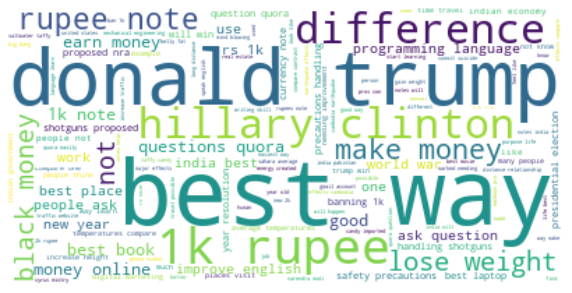

In [ ]:
wc=WordCloud(max_words=len(textp_w),stopwords=stopwords,background_color="white")
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(10,6))
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


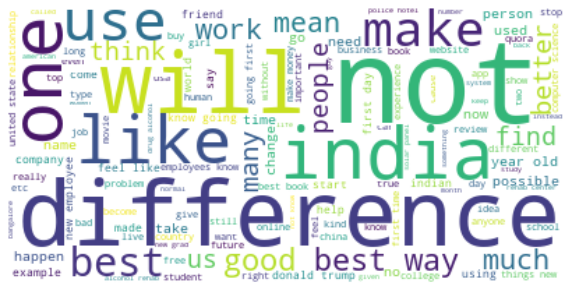

In [ ]:
wc=WordCloud(max_words=len(textn_w),stopwords=stopwords,background_color="white")
wc.generate(textn_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(10,6))
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

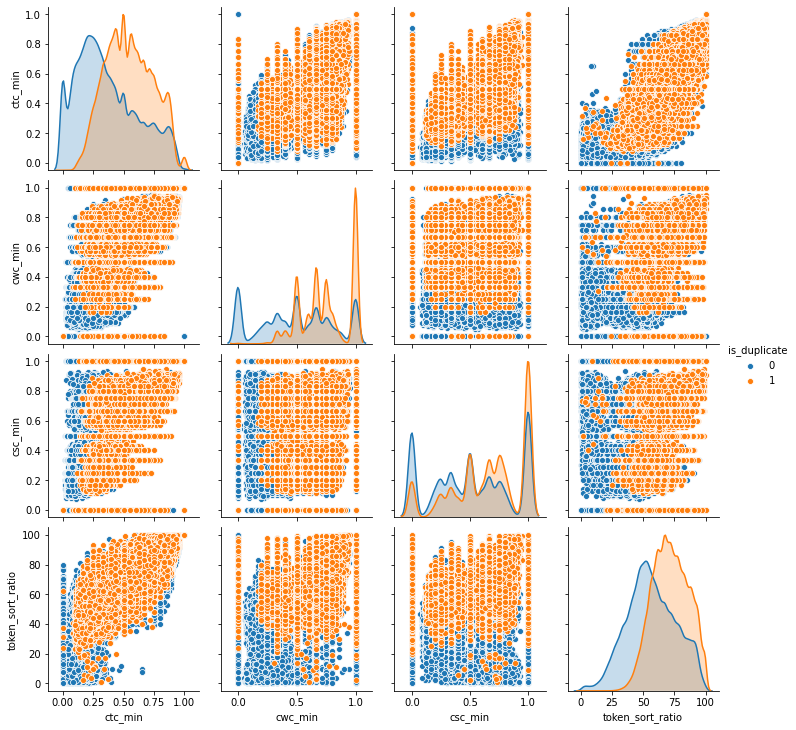

In [ ]:
n = train.shape[0]
sns.pairplot(train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [ ]:
train[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']].describe()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.587280,0.458783,0.572168,0.435548,0.433078,0.433078,0.317831,0.513641,3.777912,11.257303,71.597541,62.187356,58.407314,64.678006,0.388795
std,0.309490,0.274171,0.336518,0.299950,0.246421,0.246421,0.465634,0.499815,4.970816,5.185872,20.633393,19.125742,21.954197,18.792973,0.229686
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.399992,0.249997,0.333322,0.199996,0.243243,0.243243,0.000000,0.000000,1.000000,8.000000,58.000000,49.000000,41.000000,50.000000,0.210526
50%,0.624992,0.499975,0.599988,0.399992,0.416663,0.416663,0.000000,1.000000,2.000000,10.000000,75.000000,62.000000,59.000000,65.000000,0.344828
75%,0.799984,0.666644,0.857131,0.666644,0.624992,0.624992,1.000000,1.000000,5.000000,13.500000,89.000000,77.000000,76.000000,79.000000,0.531250
max,0.999996,0.999996,0.999995,0.999995,0.999996,0.999996,1.000000,1.000000,233.000000,140.500000,100.000000,100.000000,100.000000,100.000000,0.994186


In [ ]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = train.sample(n=10000,random_state=0)
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
def tsne_2d_lmplot(p):
    tsne2d = TSNE(n_components=2,perplexity=p,init='random',
    random_state=101,method='barnes_hut',n_iter=1000,verbose=2,angle=0.5).fit_transform(X)
    df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
    plt.title("perplexity : {} and max_iter : {}".format(p, 1000))
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 0.672s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.065031
[t-SNE] Computed conditional probabilities in 0.121s
[t-SNE] Iteration 50: error = 118.4914703, gradient norm = 0.0108530 (50 iterations in 6.155s)
[t-SNE] I

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


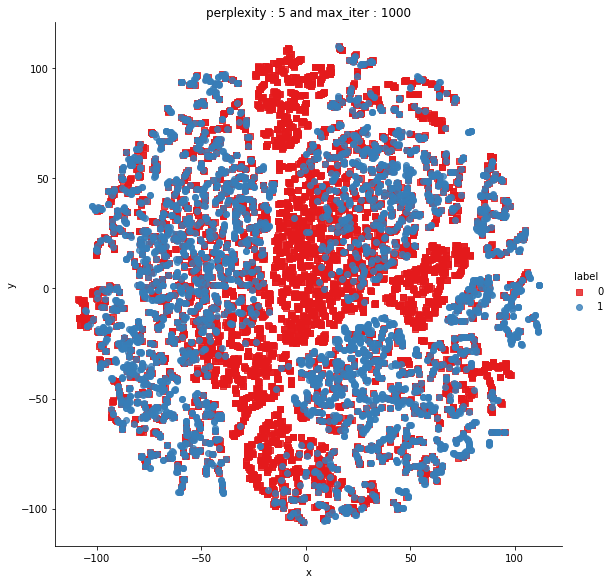

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.081s...
[t-SNE] Computed neighbors for 10000 samples in 1.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.095740
[t-SNE] Computed conditional probabilities in 0.326s
[t-SNE] Iteration 50: error = 105.0225983, gradient norm = 0.0169164 (50 iterations in 4.738s)
[t-SNE] I

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


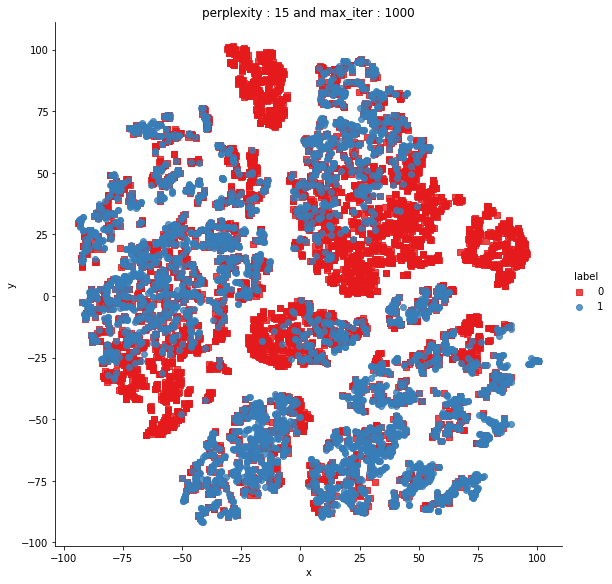

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.085s...
[t-SNE] Computed neighbors for 10000 samples in 1.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.115709
[t-SNE] Computed conditional probabilities in 0.617s
[t-SNE] Iteration 50: error = 95.9572754, gradient norm = 0.0214970 (50 iterations in 5.437s)
[t-SNE] It

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


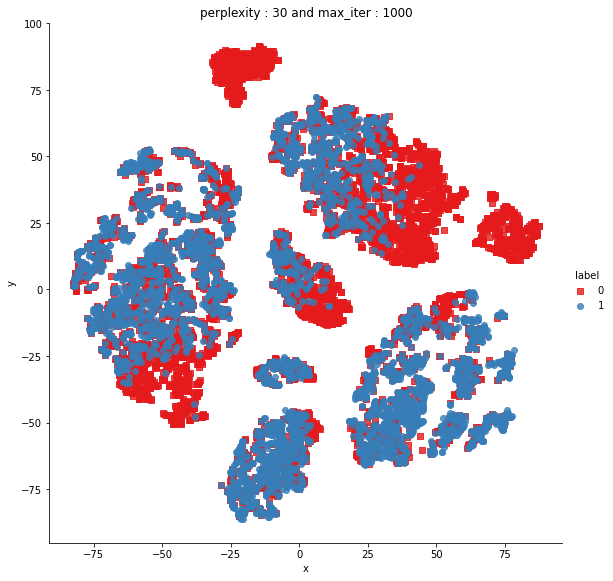

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.101s...
[t-SNE] Computed neighbors for 10000 samples in 1.498s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.132630
[t-SNE] Computed conditional probabilities in 1.013s
[t-SNE] Iteration 50: error = 89.0436020, gradient norm = 0.0239048 (50 iterations in 6.055s)
[t-SNE] I

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


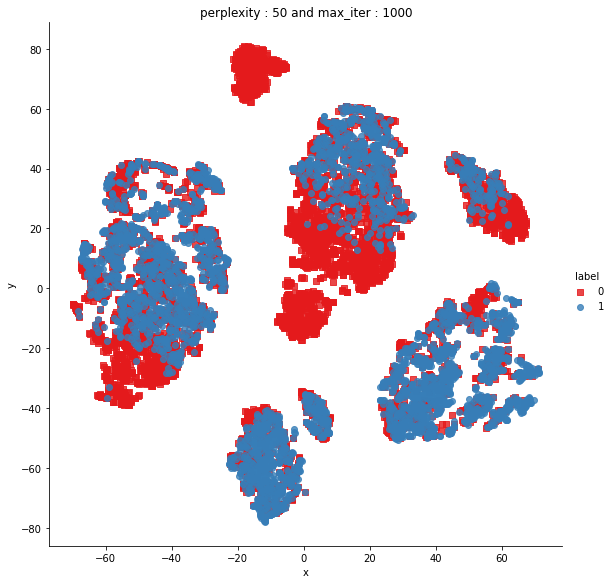

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.076s...
[t-SNE] Computed neighbors for 10000 samples in 2.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.160737
[t-SNE] Computed conditional probabilities in 1.980s
[t-SNE] Iteration 50: error = 79.9354095, gradient norm = 0.0236232 (50 iterations in 8.060s)
[t-SNE] I

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


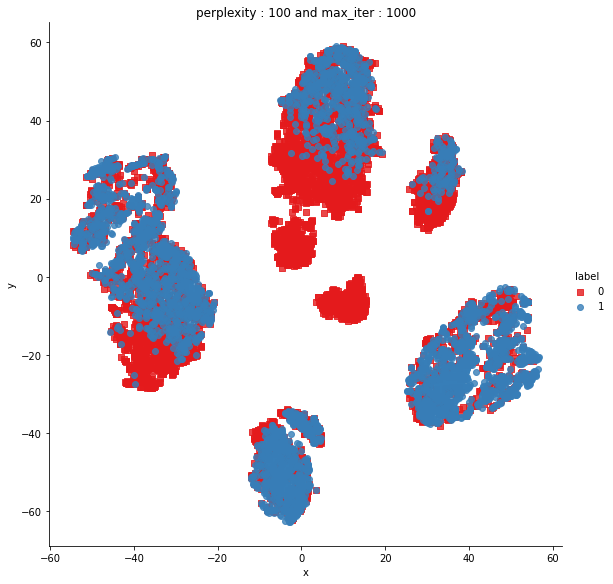

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.068s...
[t-SNE] Computed neighbors for 10000 samples in 3.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.198526
[t-SNE] Computed conditional probabilities in 3.864s
[t-SNE] Iteration 50: error = 71.3157654, gradient norm = 0.0240419 (50 iterations in 10.744s)
[t-SNE] 

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


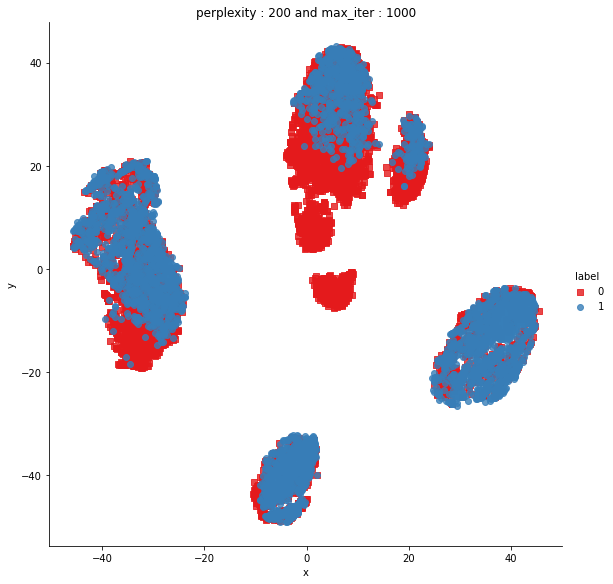

In [ ]:
tsne_2d_lmplot(5)
tsne_2d_lmplot(15)
tsne_2d_lmplot(30)
tsne_2d_lmplot(50)
tsne_2d_lmplot(100)
tsne_2d_lmplot(200)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [ ]:
df = pd.read_csv("train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=03cacaceb68f9822c2cd9494940b05f3e69cfd851352117575823480e0522798
  Stored in directory: /tmp/pip-ephem-wheel-cache-9zd7108h/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
import en_core_web_sm
import en_core_web_lg
nlp=en_core_web_sm.load()
vecs1=[]
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:12:11<00:00, 93.34it/s]


In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
if os.path.isfile('q1_features.csv'):
    q1_f = pd.read_csv("q1_features.csv",encoding='latin-1')
if os.path.isfile('q2_features.csv'):
    q2_f = pd.read_csv("q2_features.csv",encoding='latin-1')

In [ ]:
q1_f = q1_f.loc[:, ~q1_f.columns.str.contains('^Unnamed')]
q2_f = q2_f.loc[:, ~q2_f.columns.str.contains('^Unnamed')]

In [ ]:
q1_f.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :",df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    q1_f['id']=df1['id']
    q2_f['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = q1_f.merge(q1_f, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [ ]:
result.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.785709,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,23.0,0.434783,2,0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,1,0,0.799984,0.399996,0.749981,0.599988,0.466664,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,20.0,0.200000,5,3,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,2,0,0.399992,0.333328,0.399992,0.249997,0.285712,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,24.0,0.166667,2,0,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,19.0,0.000000,2,0,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,4,0,0.399992,0.199998,0.999950,0.666644,0.307690,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,20.0,0.100000,4,2,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,...,130.827244,37.638571,-35.975133,57.951976,132.426440,-88.766826,53.316818,87.492634,8.261116,52.414855,27.674768,-154.374645,-159.211448,105.795546,26.884158,-75.462894,72.557292,70.700351,-132.216330,-63.143468,100.091403,11.778892,49.447504,6.032554,91.693478,-230.983545,-85.245530,130.453435,3.544366,-47.737812,-4.390959,109.604406,-91.160167,-25.739913,133.123058,-13.508816,-100.115211,208.42438

In [ ]:
if os.path.isfile('final_features.csv'):
  data = pd.read_csv("final_features.csv",encoding='latin-1')
  data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [ ]:
data.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.785709,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,23.0,0.434783,2,0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,1,0,0.799984,0.399996,0.749981,0.599988,0.466664,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,20.0,0.200000,5,3,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,2,0,0.399992,0.333328,0.399992,0.249997,0.285712,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,24.0,0.166667,2,0,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,19.0,0.000000,2,0,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,4,0,0.399992,0.199998,0.999950,0.666644,0.307690,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,20.0,0.100000,4,2,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,...,130.827244,37.638571,-35.975133,57.951976,132.426440,-88.766826,53.316818,87.492634,8.261116,52.414855,27.674768,-154.374645,-159.211448,105.795546,26.884158,-75.462894,72.557292,70.700351,-132.216330,-63.143468,100.091403,11.778892,49.447504,6.032554,91.693478,-230.983545,-85.245530,130.453435,3.544366,-47.737812,-4.390959,109.604406,-91.160167,-25.739913,133.123058,-13.508816,-100.115211,208.42438

In [ ]:
y_true = data['is_duplicate']
data.drop(['id','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.999980,0.833319,0.999983,0.999983,0.785709,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,23.0,0.434783,2,0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,0.799984,0.399996,0.749981,0.599988,0.466664,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,20.0,0.200000,5,3,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,0.399992,0.333328,0.399992,0.249997,0.285712,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,24.0,0.166667,2,0,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,19.0,0.000000,2,0,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,0.399992,0.199998,0.999950,0.666644,0.307690,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,20.0,0.100000,4,2,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,...,130.827244,37.638571,-35.975133,57.951976,132.426440,-88.766826,53.316818,87.492634,8.261116,52.414855,27.674768,-154.374645,-159.211448,105.795546,26.884158,-75.462894,72.557292,70.700351,-132.216330,-63.143468,100.091403,11.778892,49.447504,6.032554,91.693478,-230.983545,-85.245530,130.453435,3.544366,-47.737812,-4.

In [ ]:
#splitting the data into 70:30
X_train,X_test,y_train,y_test=train_test_split(data,y_true,stratify=y_true,test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(283003, 217)
(121287, 217)


In [ ]:
print('-'*10,"Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)  
    B =(C/C.sum(axis=0))

    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing A in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8863945873091347


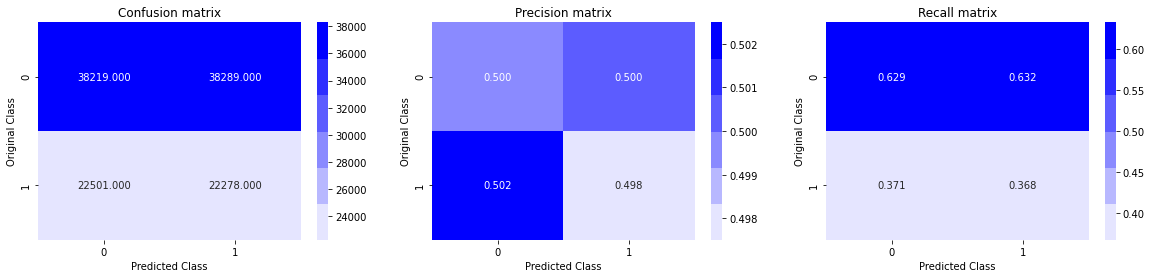

In [ ]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.43693179676722926
For values of alpha =  0.0001 The log loss is: 0.449251636189286
For values of alpha =  0.001 The log loss is: 0.4420639321411094
For values of alpha =  0.01 The log loss is: 0.4342204413878131
For values of alpha =  0.1 The log loss is: 0.4633627219067715
For values of alpha =  1 The log loss is: 0.49690043861710165
For values of alpha =  10 The log loss is: 0.5313622462770665


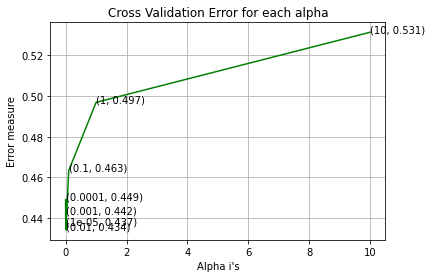

For values of best alpha =  0.01 The train log loss is: 0.4342378587142626
For values of best alpha =  0.01 The test log loss is: 0.4342204413878131
Total number of data points : 121287


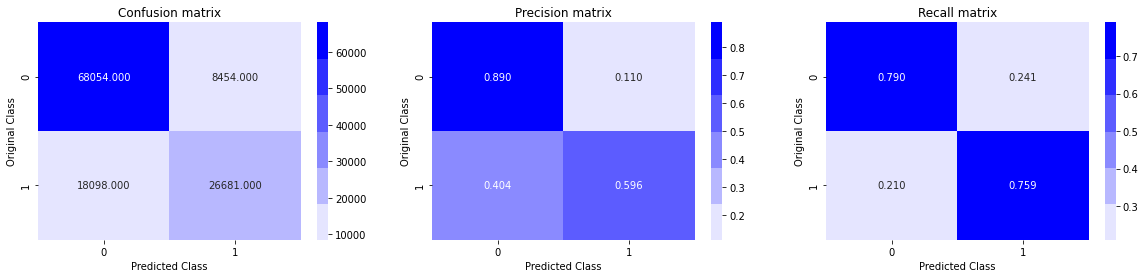

In [ ]:
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

[0]	train-logloss:0.684536	valid-logloss:0.684843
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615204	valid-logloss:0.615295
[20]	train-logloss:0.564601	valid-logloss:0.564597
[30]	train-logloss:0.526371	valid-logloss:0.526541
[40]	train-logloss:0.497641	valid-logloss:0.497619
[50]	train-logloss:0.474407	valid-logloss:0.474473
[60]	train-logloss:0.456284	valid-logloss:0.456287
[70]	train-logloss:0.441671	valid-logloss:0.441717
[80]	train-logloss:0.42983	valid-logloss:0.429859
[90]	train-logloss:0.420229	valid-logloss:0.420245
[100]	train-logloss:0.412305	valid-logloss:0.412345
[110]	train-logloss:0.405547	valid-logloss:0.405687
[120]	train-logloss:0.400023	valid-logloss:0.40012
[130]	train-logloss:0.395261	valid-logloss:0.395383
[140]	train-logloss:0.391287	valid-logloss:0.391473
[150]	train-logloss:0.38783	valid-logloss:0.388038
[160]	train-logloss:0.384855	va

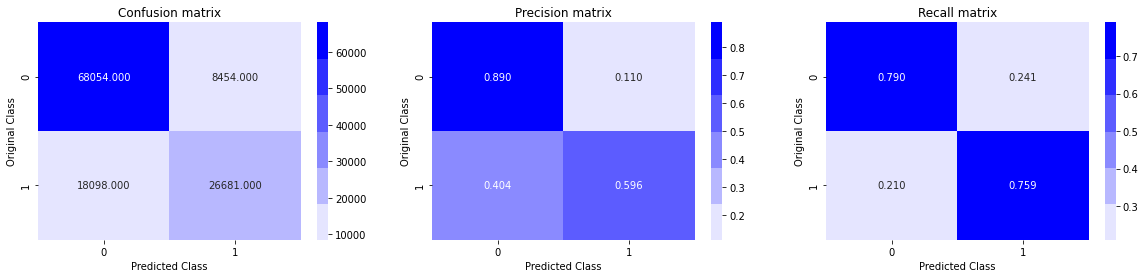

In [ ]:
mport xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 700, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
import xgboost as xgb
#A parameter grid for XGBoost
params = {
        'learning_rate':[0.001,0.01,0.1], 
        'min_child_weight': [6,8,10],
        'gamma': [0.25, 0.50, 0.75],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'max_depth': [6,8,10],
        'n_estimators' : [50,100,150]
        }


xgb = xgb.XGBClassifier(objective='binary:logistic',eta=0.02, silent=False,n_jobs=-1, verbose=10)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, scoring='neg_log_loss',n_jobs=-1, cv=5, verbose=10, random_state=0)
random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)

print("Best log loss obtained on Cross Validation data using hyperparameter tuning: ",random_search.best_score_)

#Save ranbdom search results in a datframe
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

[0]	train-logloss:0.688374	validation-logloss:0.68848
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[2]	train-logloss:0.679516	validation-logloss:0.679609
[4]	train-logloss:0.670872	validation-logloss:0.670891
[6]	train-logloss:0.661771	validation-logloss:0.661989
[8]	train-logloss:0.653012	validation-logloss:0.653352
[10]	train-logloss:0.644782	validation-logloss:0.645086
[12]	train-logloss:0.636907	validation-logloss:0.637229
[14]	train-logloss:0.629111	validation-logloss:0.629479
[16]	train-logloss:0.621581	validation-logloss:0.622064
[18]	train-logloss:0.614228	validation-logloss:0.614676
[20]	train-logloss:0.607367	validation-logloss:0.607708
[22]	train-logloss:0.600505	validation-logloss:0.600903
[24]	train-logloss:0.593833	validation-logloss:0.594512
[26]	train-logloss:0.587694	validation-logloss:0.588198
[28]	train-logloss:0.581606	validation-logloss:0.582277
[30]	

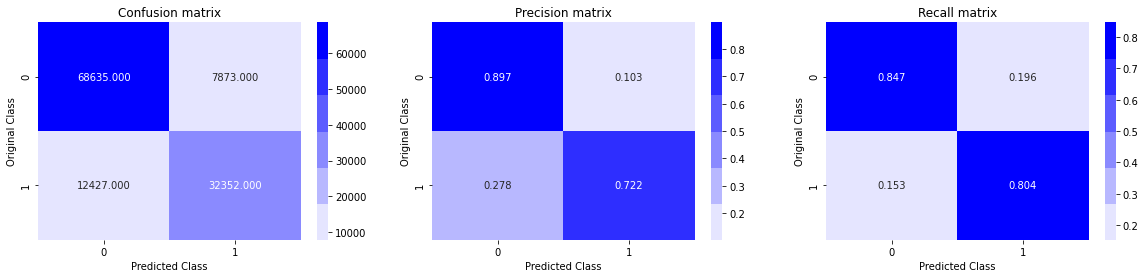

In [ ]:
#Best Hyperparameters are: 'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 8, 'max_depth': 8, 'gamma': 0.25, 'colsample_bytree': 0.7

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['learning_rate']=0.01
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 8
params['subsample'] = 0.6
params['n_estimators'] = 150
params['min_child_weight'] = 8
params['gamma'] = 0.25
params['colsample_bytree'] = 0.7

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'validation')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=20, verbose_eval=2)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("\nThe train log loss is:",log_loss(y_train, bst.predict(d_train), labels=[0, 1], eps=1e-15))
print("\nThe test log loss is:",log_loss(y_test, predict_y, labels=[0, 1], eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("\nTotal number of validation data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [ ]:
#df1=df1.drop('Unnamed: 0',axis=1)
df3 = df3.fillna(' ')
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left')
X  = final_df.merge(new_df, on='id',how='left')

In [ ]:
X=X.drop('id',axis=1)

In [ ]:
X.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_share,freq_q1+q2,freq_q1-q2,questions
0,0.999980,0.833319,0.999983,0.999983,0.785709,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,23.0,0.434783,2,0,what is the step by step guide to invest in sh...
1,0.799984,0.399996,0.749981,0.599988,0.466664,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...
2,0.399992,0.333328,0.399992,0.249997,0.285712,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,1,1,73,59,14,10,24.0,0.166667,2,0,how can i increase the speed of my internet co...
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,1,1,50,65,11,9,19.0,0.000000,2,0,why am i mentally very lonely how can i solve...
4,0.399992,0.199998,0.999950,0.666644,0.307690,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,3,1,76,39,13,7,20.0,0.100000,4,2,which one dissolve in water quikly sugar salt...


In [ ]:
y=np.array(duplicate)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283003, 26)
(283003,)
(121287, 26)
(121287,)


In [ ]:
X_train_q=X_train['questions']
X_test_q=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
X_train_tfidf=tf_idf_vect.fit_transform(X_train_q)
X_test_tfidf=tf_idf_vect.transform(X_test_q)

In [ ]:
from scipy.sparse import hstack

X_train = hstack((X_train.values,X_train_tfidf))
X_test= hstack((X_test.values,X_test_tfidf))
print(X_train.shape)
print(X_test.shape)

(283003, 74033)
(121287, 74033)


For values of alpha =  1e-05 The log loss is: 0.3937049607865568
For values of alpha =  0.0001 The log loss is: 0.3940603959474815
For values of alpha =  0.001 The log loss is: 0.439443018621326
For values of alpha =  0.01 The log loss is: 0.4698162263719882
For values of alpha =  0.1 The log loss is: 0.490643449617516
For values of alpha =  1 The log loss is: 0.515221559632586
For values of alpha =  10 The log loss is: 0.5475606340431745


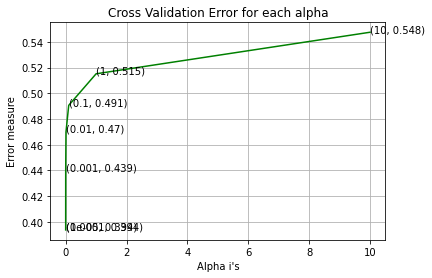

For values of best alpha =  1e-05 The train log loss is: 0.3918626272317136
For values of best alpha =  1e-05 The test log loss is: 0.3937049607865568
Total number of data points : 121287


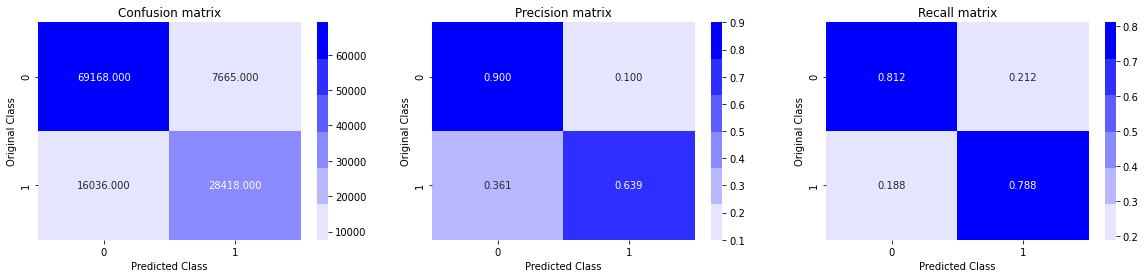

In [ ]:
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.43175799251001323
For values of alpha =  0.0001 The log loss is: 0.43647022325657675
For values of alpha =  0.001 The log loss is: 0.4476046502923639
For values of alpha =  0.01 The log loss is: 0.4717499544167244
For values of alpha =  0.1 The log loss is: 0.5223996205445786


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  1 The log loss is: 0.5758930064002137


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


For values of alpha =  10 The log loss is: 0.5851884526665334


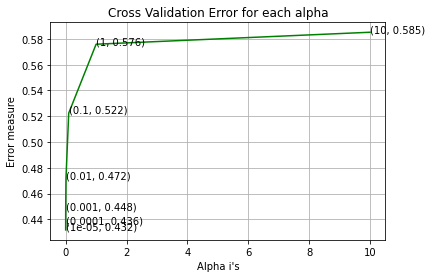

For values of best alpha =  1e-05 The train log loss is: 0.42956254717354647
For values of best alpha =  1e-05 The test log loss is: 0.43175799251001323
Total number of data points : 121287


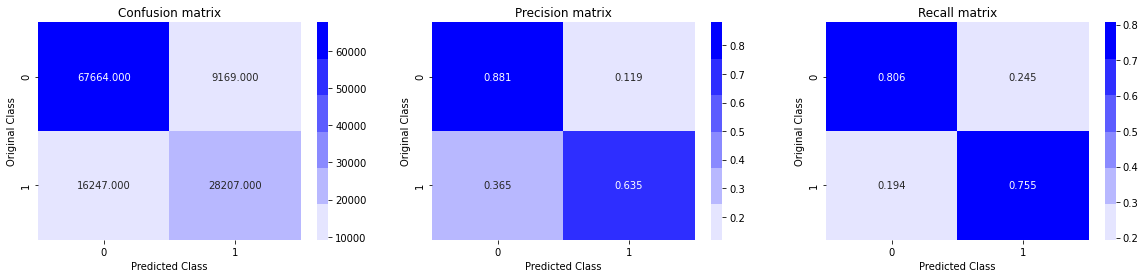

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
import xgboost as xgb
#A parameter grid for XGBoost
params = {
        'learning_rate':[0.001,0.01,0.1], 
        'min_child_weight': [6,8,10],
        'gamma': [0.25, 0.50, 0.75],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.5, 0.6, 0.7],
        'max_depth': [6,8,10],
        'n_estimators' : [50,100,150]
        }


xgb = xgb.XGBClassifier(objective='binary:logistic',eta=0.02, silent=False,n_jobs=-1, verbose=10)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=30, scoring='neg_log_loss',n_jobs=-1, cv=5, verbose=10, random_state=0)
random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)

print("Best log loss obtained on Cross Validation data using hyperparameter tuning: ",random_search.best_score_)

#Save ranbdom search results in a datframe
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 69.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 77.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 93.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 117.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 134.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 154.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 188.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 234.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 270.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elaps


 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 8, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.75, 'colsample_bytree': 0.7}
Best log loss obtained on Cross Validation data using hyperparameter tuning:  -0.3098888604282912


[0]	train-logloss:0.644701	validation-logloss:0.645313
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[2]	train-logloss:0.57189	validation-logloss:0.5742
[4]	train-logloss:0.519098	validation-logloss:0.5226
[6]	train-logloss:0.477252	validation-logloss:0.481791
[8]	train-logloss:0.445719	validation-logloss:0.451166
[10]	train-logloss:0.421615	validation-logloss:0.427963
[12]	train-logloss:0.40226	validation-logloss:0.409223
[14]	train-logloss:0.387074	validation-logloss:0.394834
[16]	train-logloss:0.374429	validation-logloss:0.383176
[18]	train-logloss:0.364013	validation-logloss:0.373564
[20]	train-logloss:0.355758	validation-logloss:0.365875
[22]	train-logloss:0.349209	validation-logloss:0.359994
[24]	train-logloss:0.343131	validation-logloss:0.35444
[26]	train-logloss:0.33772	validation-logloss:0.349569
[28]	train-logloss:0.33276	validation-logloss:0.345482
[30]	train-lo

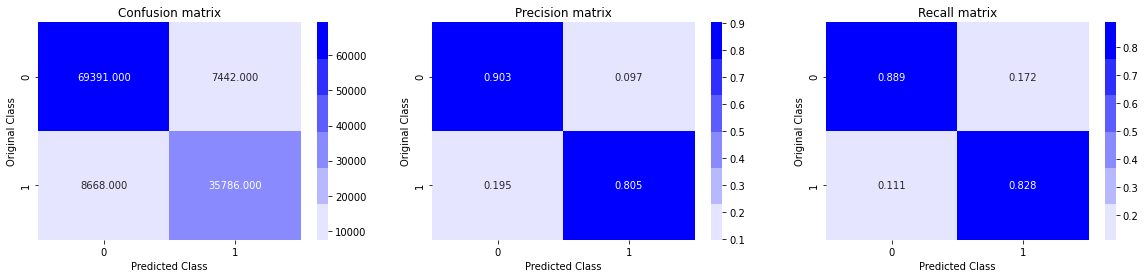

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['learning_rate']=0.1
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['subsample'] = 0.6
params['n_estimators'] = 150
params['min_child_weight'] = 8
params['gamma'] = 0.75
params['colsample_bytree'] = 0.7

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'validation')]
bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=20, verbose_eval=2)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("\nThe train log loss is:",log_loss(y_train, bst.predict(d_train), labels=[0, 1], eps=1e-15))
print("\nThe test log loss is:",log_loss(y_test, predict_y, labels=[0, 1], eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("\nTotal number of validation data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","log loss"]
x.add_row(['Random Model','TFIDF w2vec','0.88'])
x.add_row(['Logistic regression','TFIDF w2vec','0.43'])
x.add_row(['XGBOOST','TFIDF w2vec','0.34'])
x.add_row(['XGBOOST Hyperparameters','TFIDF w2vec','0.33'])
x.add_row(['Logistic regression','TFIDF ','0.39'])
x.add_row(['Linear SVM','TFIDF','0.43'])
x.add_row(['XGBOOST Hyperparameters','TFIDF ','0.28'])
print(x)

+-------------------------+-------------+----------+
|          Model          |  vectorizer | log loss |
+-------------------------+-------------+----------+
|       Random Model      | TFIDF w2vec |   0.88   |
|   Logistic regression   | TFIDF w2vec |   0.43   |
|         XGBOOST         | TFIDF w2vec |   0.34   |
| XGBOOST Hyperparameters | TFIDF w2vec |   0.33   |
|   Logistic regression   |    TFIDF    |   0.39   |
|        Linear SVM       |    TFIDF    |   0.43   |
| XGBOOST Hyperparameters |    TFIDF    |   0.28   |
+-------------------------+-------------+----------+
